# Using Machine Learning Tools: Workshop 7

The aim of this week's workshop is to use support vector machines (SVMs), compare different kernels and visualise the decision boundaries.

You will use [Wisconsin Breast Cancer data set](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset), which is included in scikit learn (follow the link and read about what the dataset is)

Note: the link on webpage to the dataset is 'dead'. However, you can load the data directly using the below (as used in the below code):

`from sklearn.datasets import load_breast_cancer`

`data = load_breast_cancer()`


# Part 1 [Students, 2 min]: Setup and loading data

Use the cells below to setup the notebook and load in data.

In [1]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To plot even prettier figures
import seaborn as sn

# General data handling (pure numerics are better in numpy)
import pandas as pd

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [3]:
# Extract the feature and target
xarray = data.data
yarray = data.target
print(xarray.shape)
print(yarray.shape)
fullarray = np.concatenate((xarray,np.reshape(yarray,(-1,1))),axis=1)
print(fullarray.shape)

(569, 30)
(569,)
(569, 31)


# Part 2.1 [Students, 15 min]: Viewing the data and visualising features

We want to have a look at the data, and get a better understanding of the various features included. It is also a good idea to try and look at the relationship between each feature and the target (what we are trying to predict). Try to come up with some useful visualisation and data inspection steps to get an idea of this.



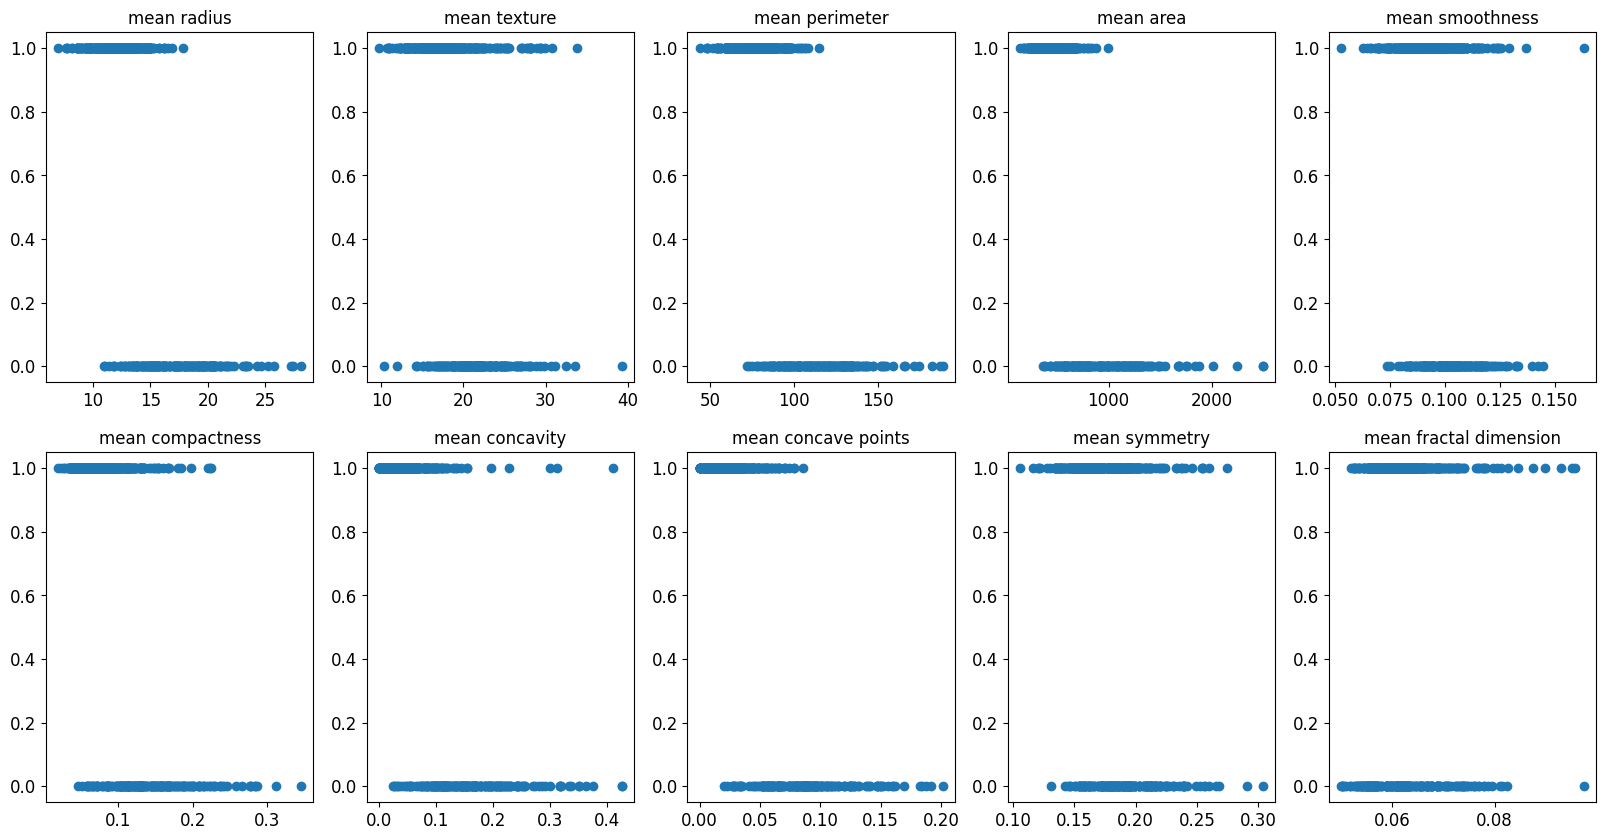

In [13]:
fig, axs = plt.subplots(2,5, figsize=(20, 10))  

for i in range(5):
    axs[0, i].scatter(xarray[:,i],yarray)
    axs[0, i].set_title(data.feature_names[i])
    
for i in range(5,10):
    axs[1, i-5].scatter(xarray[:,i],yarray)
    axs[1, i-5].set_title(data.feature_names[i])


In [15]:
# Dataframe
x_df = pd.DataFrame(xarray, columns=data.feature_names)
df = x_df.copy()
df['target'] = yarray
df.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension  target  
0          0.4601                  0.11890       0  
1          0.2750                  0.08902       0  
2          0.3613                  0.08758       0  
3          0.6638                  0.17300       0  
4          0.2364                  0.07678       0  

[5 rows x 31 columns]

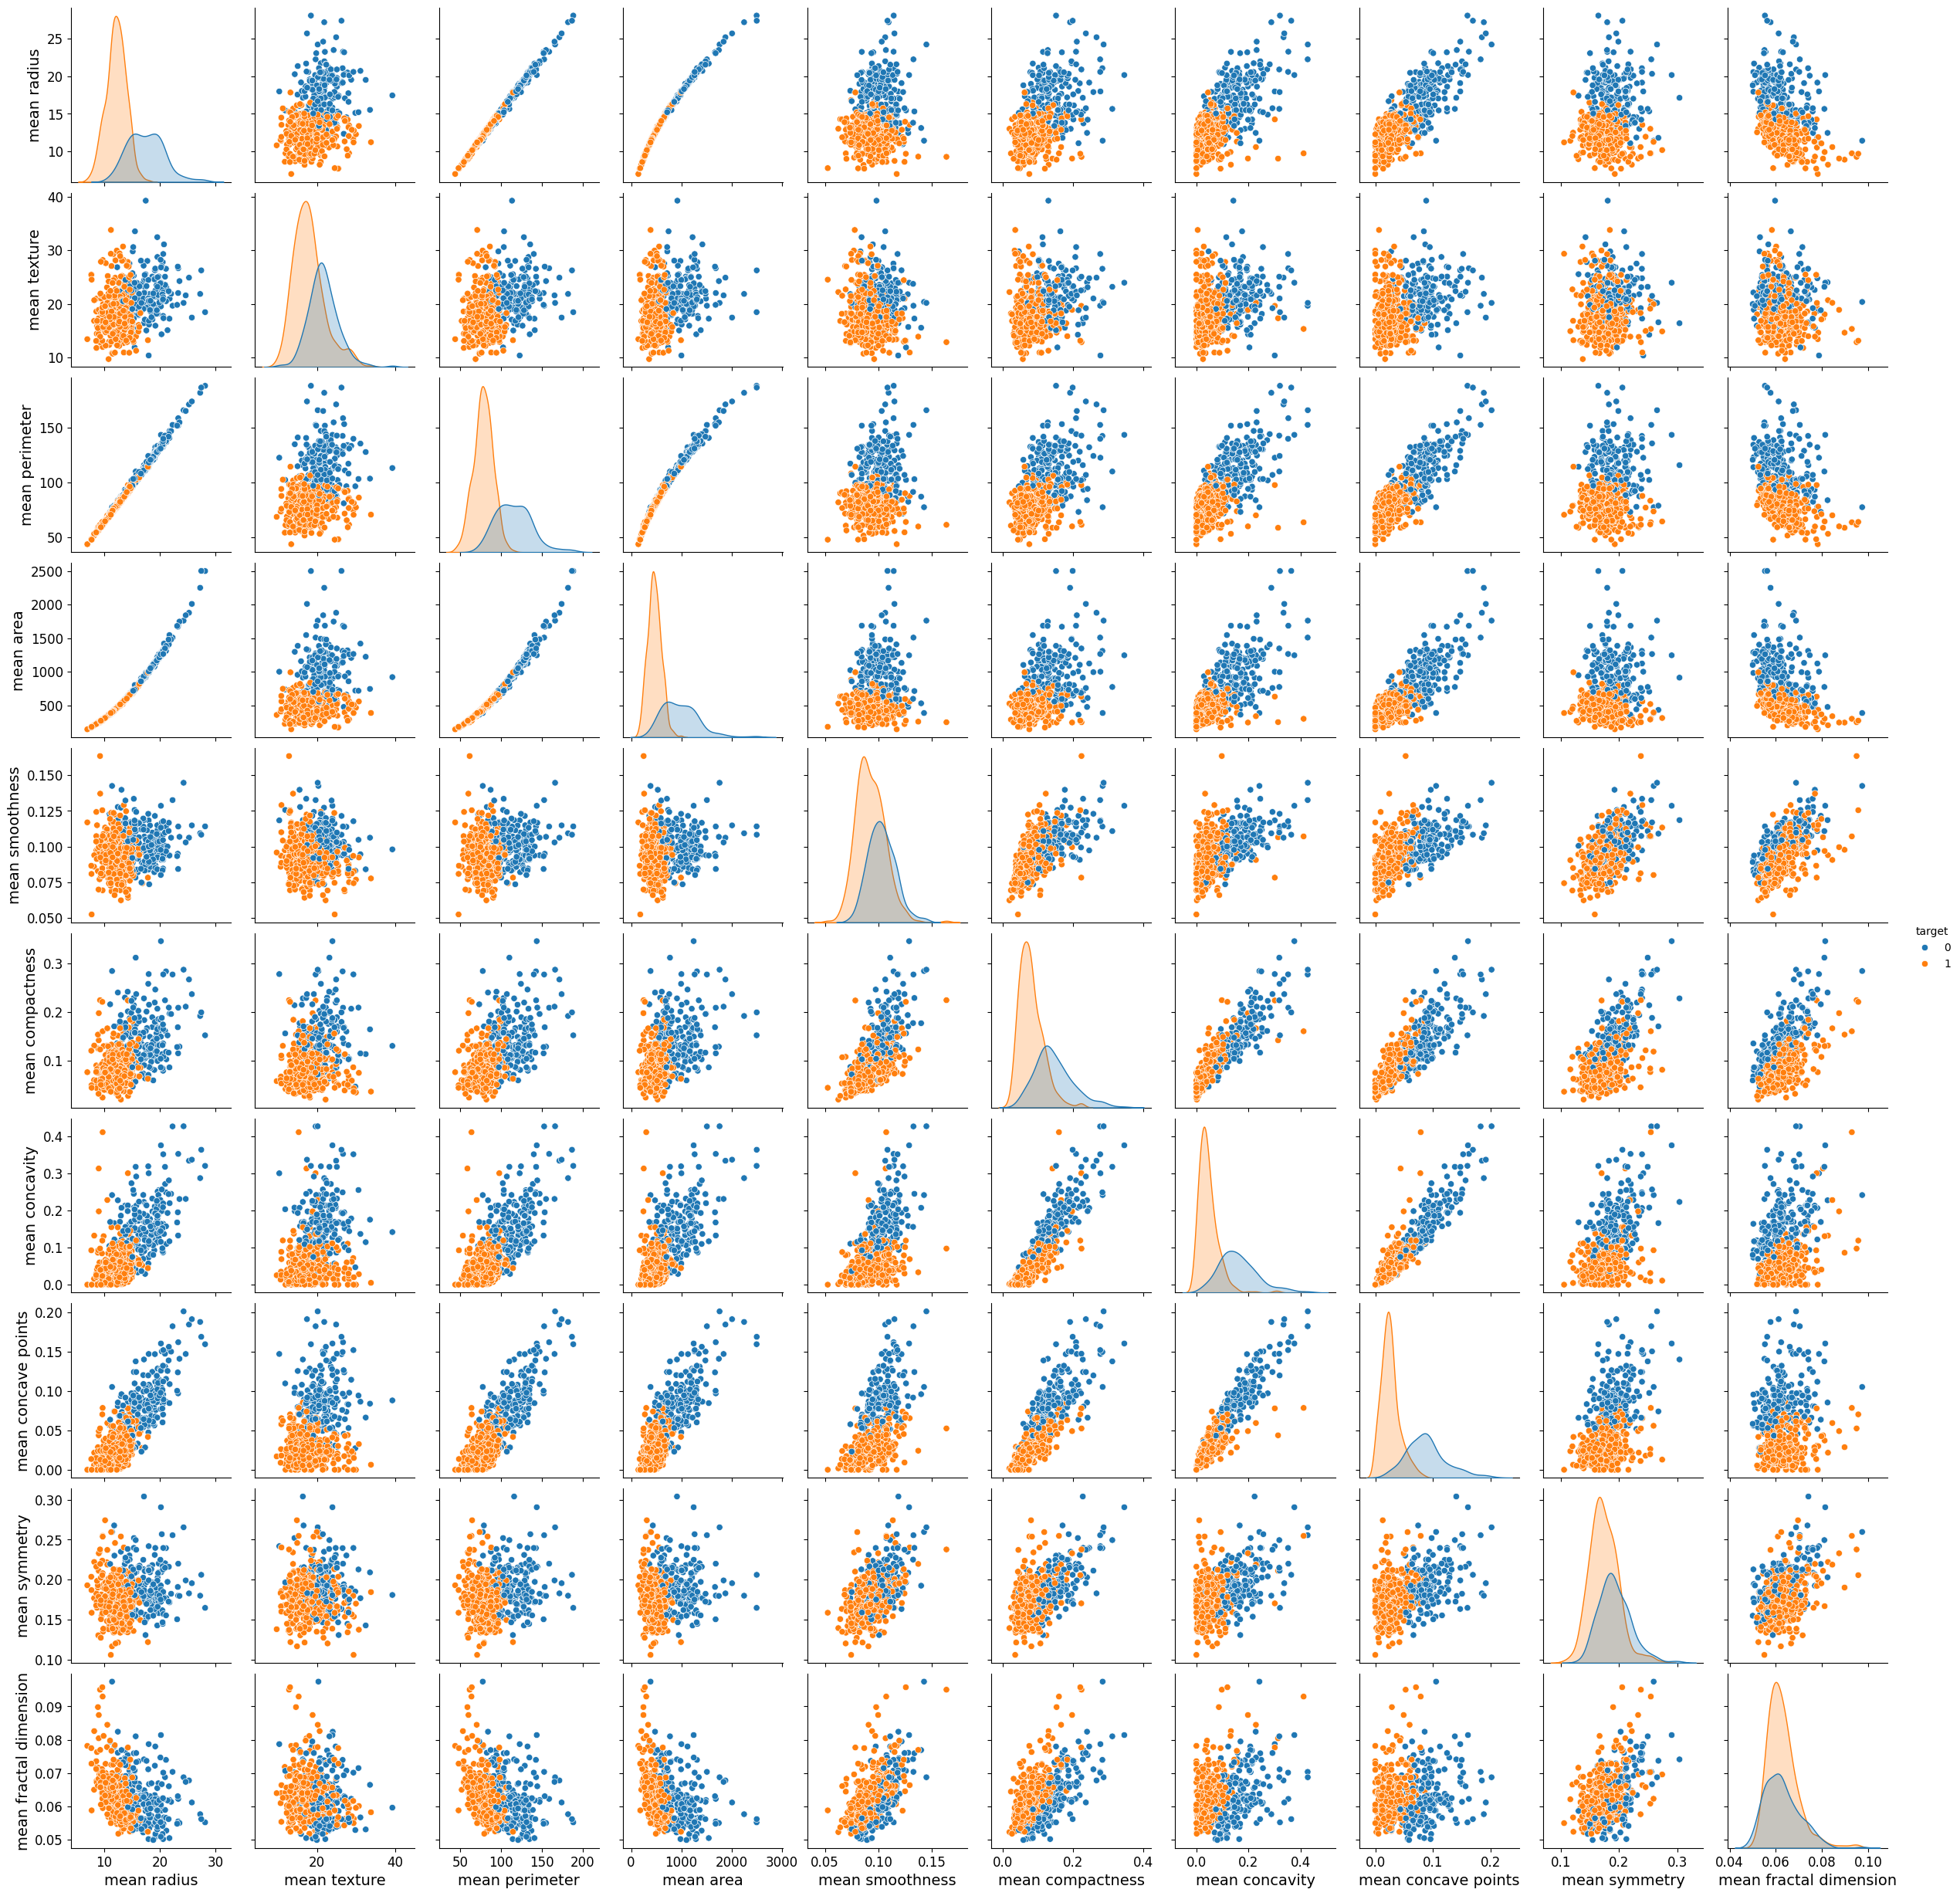

In [23]:
sn.pairplot(df, hue='target', vars=[x for x in df.columns if 'mean' in x] , diag_kind='kde')

<Axes: >

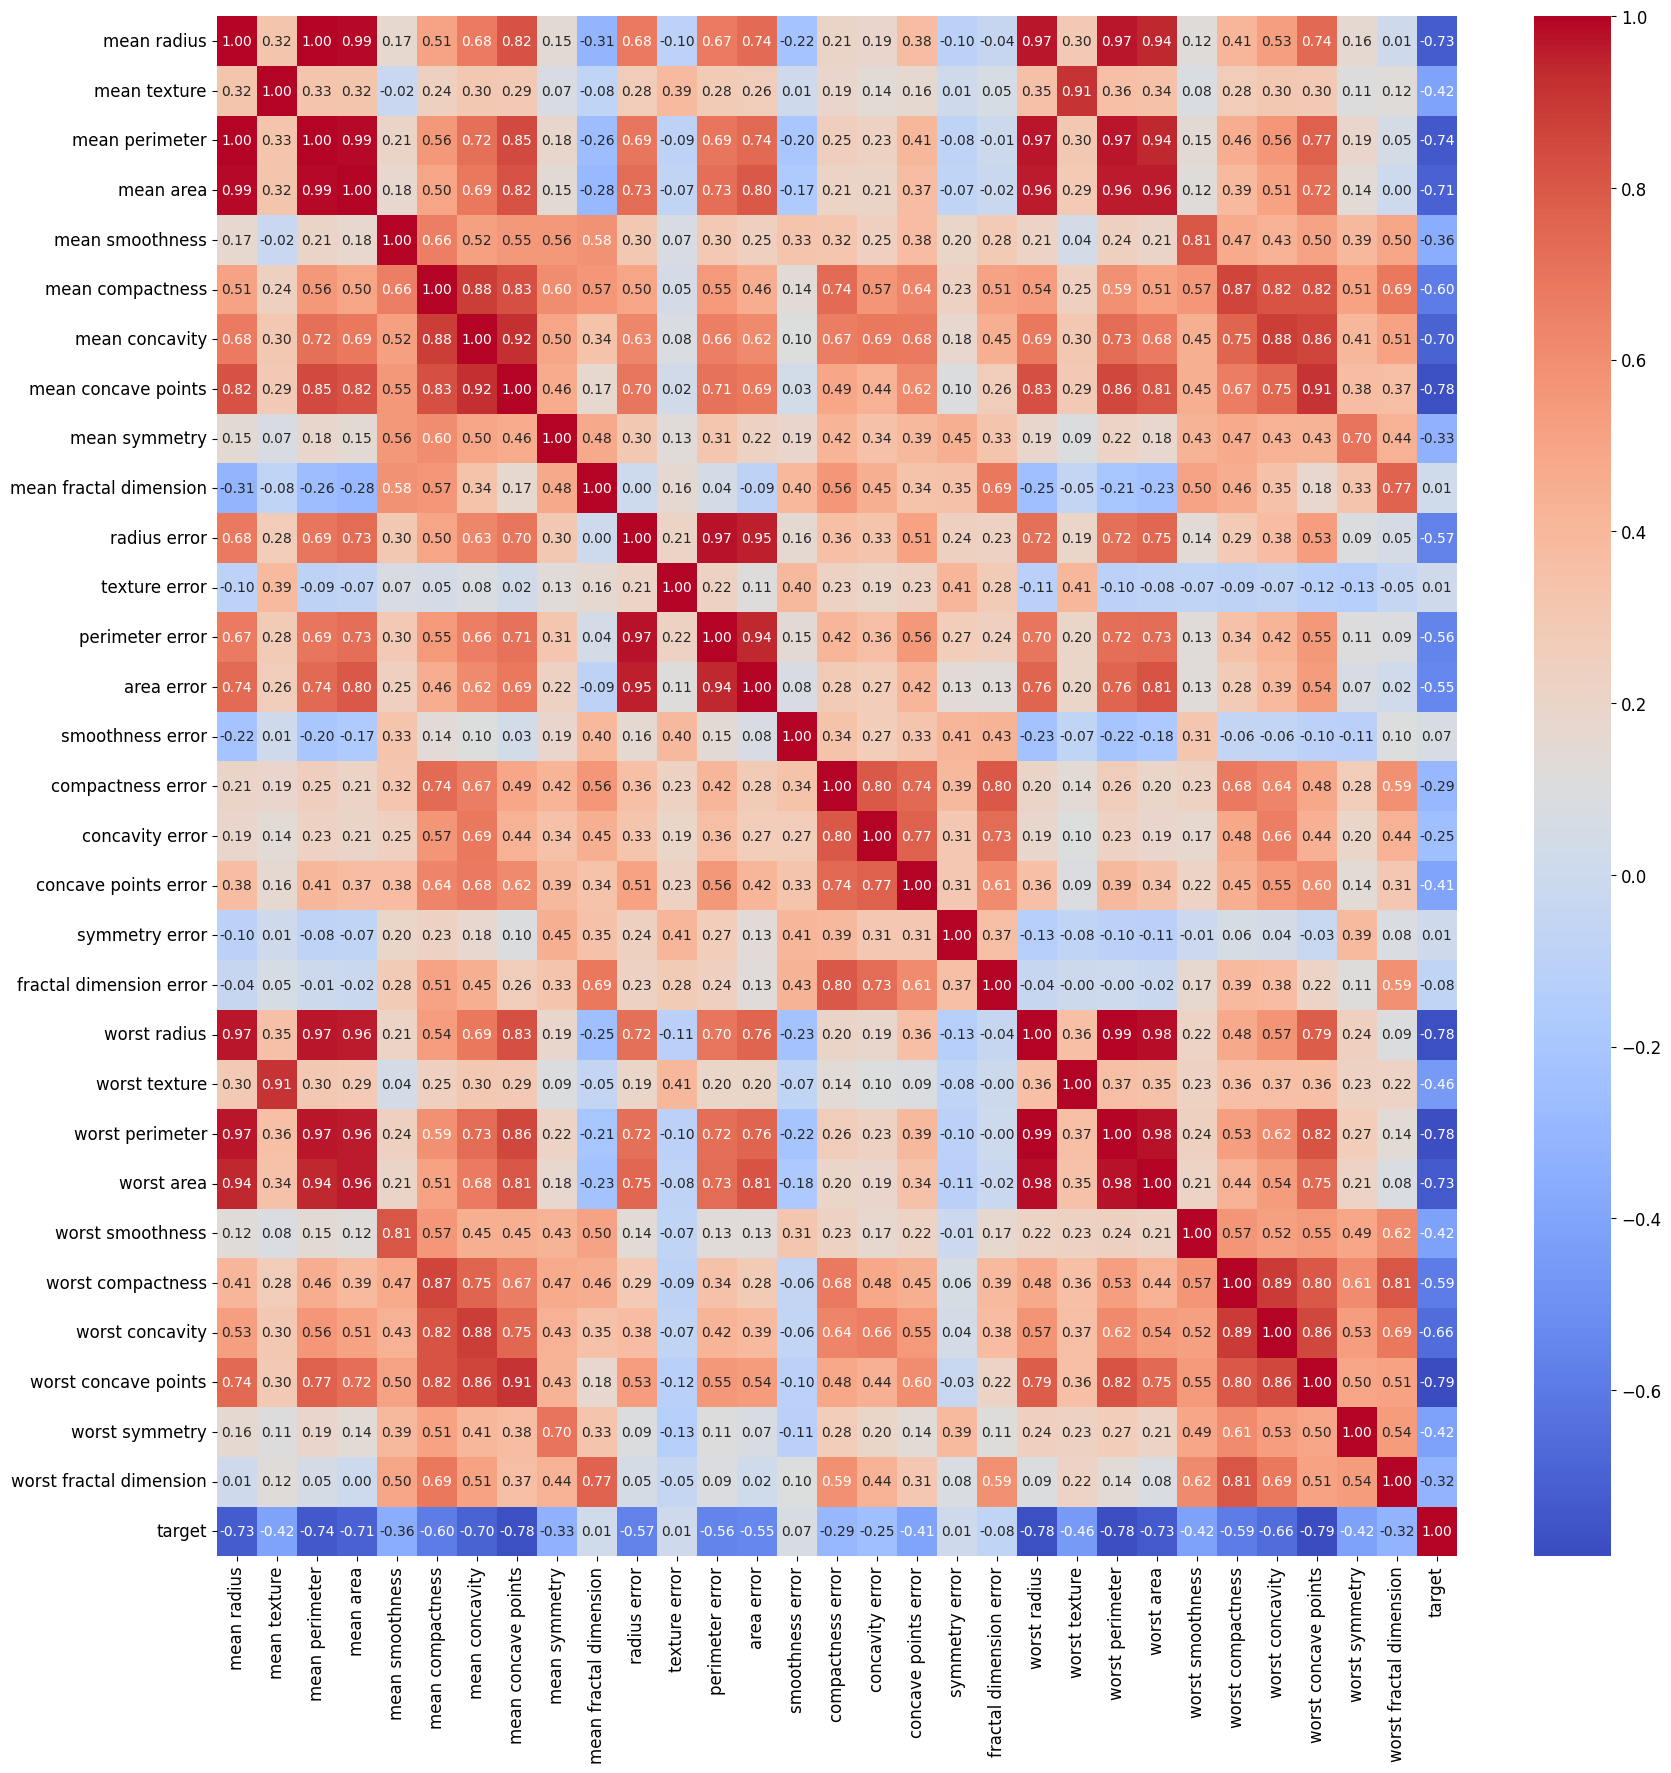

In [25]:
plt.figure(figsize=(20, 20))
sn.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Part [Students, 10 min]: Splitting into separate datasets using `stratify`

We next want to split out data into training, testing and validation sets as we have previously done, but want to specifically use `stratify`.

Why use `stratify`?

* Maintaining Class Proportions: When dealing with classification problems, it is crucial to maintain the same proportion of each class in the training, testing, and validation sets as in the original dataset. This ensures that each subset is representative of the overall class distribution, which is especially important if the dataset is imbalanced.
* Improved Model Performance: By keeping the class distribution consistent across all subsets, the model is trained on a dataset that is more reflective of the real-world scenario, which can lead to better generalization and improved performance on unseen data.
* Avoiding Bias: Without stratification, there is a risk that the training set might end up with a disproportionate number of samples from certain classes, which can introduce bias and negatively impact the model’s ability to learn effectively.

Try and write some code to use stratify and ensure each dataset has roughly the same proportions of the classes. You can use ChatGPT to help.

In [26]:
from sklearn.model_selection import train_test_split

# Split in train, validation and test. Check the parameter "stratify"
x_train, x_test, y_train, y_test = train_test_split(xarray, yarray, test_size=0.2, random_state=3, stratify=yarray)

**Note the use of "stratify" in the calls above, as these make sure that each dataset has roughly the same proportions of the classes.**

# Part 4 [Student, 25 min]: Pipeline and SVM classifier

Build an SVM classifier, in a pipeline, with a linear function (linear) kernel, default (hyper)parameters and determine the accuracy of this classifier on the validation set.

In particular, we want to establish a simple baseline to compare accuracy values, much as we did in the earlier workshop on regression.  Here we will do it for each feature separately, turning the feature values into a simple “prediction probability” by using the formula: y_pred = (x-xmin)/(xmax-xmin) which gives values in the range 0 and 1 (inclusive).

Start with the first feature and write a loop to threshold this prediction (y_pred) at a set of evenly spaced values between 0 and 1, and for each threshold calculate the accuracy. From this determine the maximum accuracy (across all your tested thresholds) for that feature.

Now do this for each feature in turn.  Which feature gives the best accuracy and how does this compare to the SVM result?  What is the name of this feature?

Try to write some code to do this, which you can use ChatGPT's help for.

# Pipeline

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

preproc_pl = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

x_train_2, x_val, y_train_2, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=3, stratify=y_train)

In [67]:
transformed_x_train = preproc_pl.fit_transform(x_train_2)
transformed_x_val = preproc_pl.transform(x_val)
thresholds = np.linspace(0, 1, 50)
scores = {}

for col in range(transformed_x_train.shape[1]):
    scores[data.feature_names[col]] = []
    for t in thresholds:
        y_pred = (transformed_x_val[:,col] > t).astype(int)
        accuracy = accuracy_score(y_val, y_pred)
        scores[data.feature_names[col]].append(accuracy)

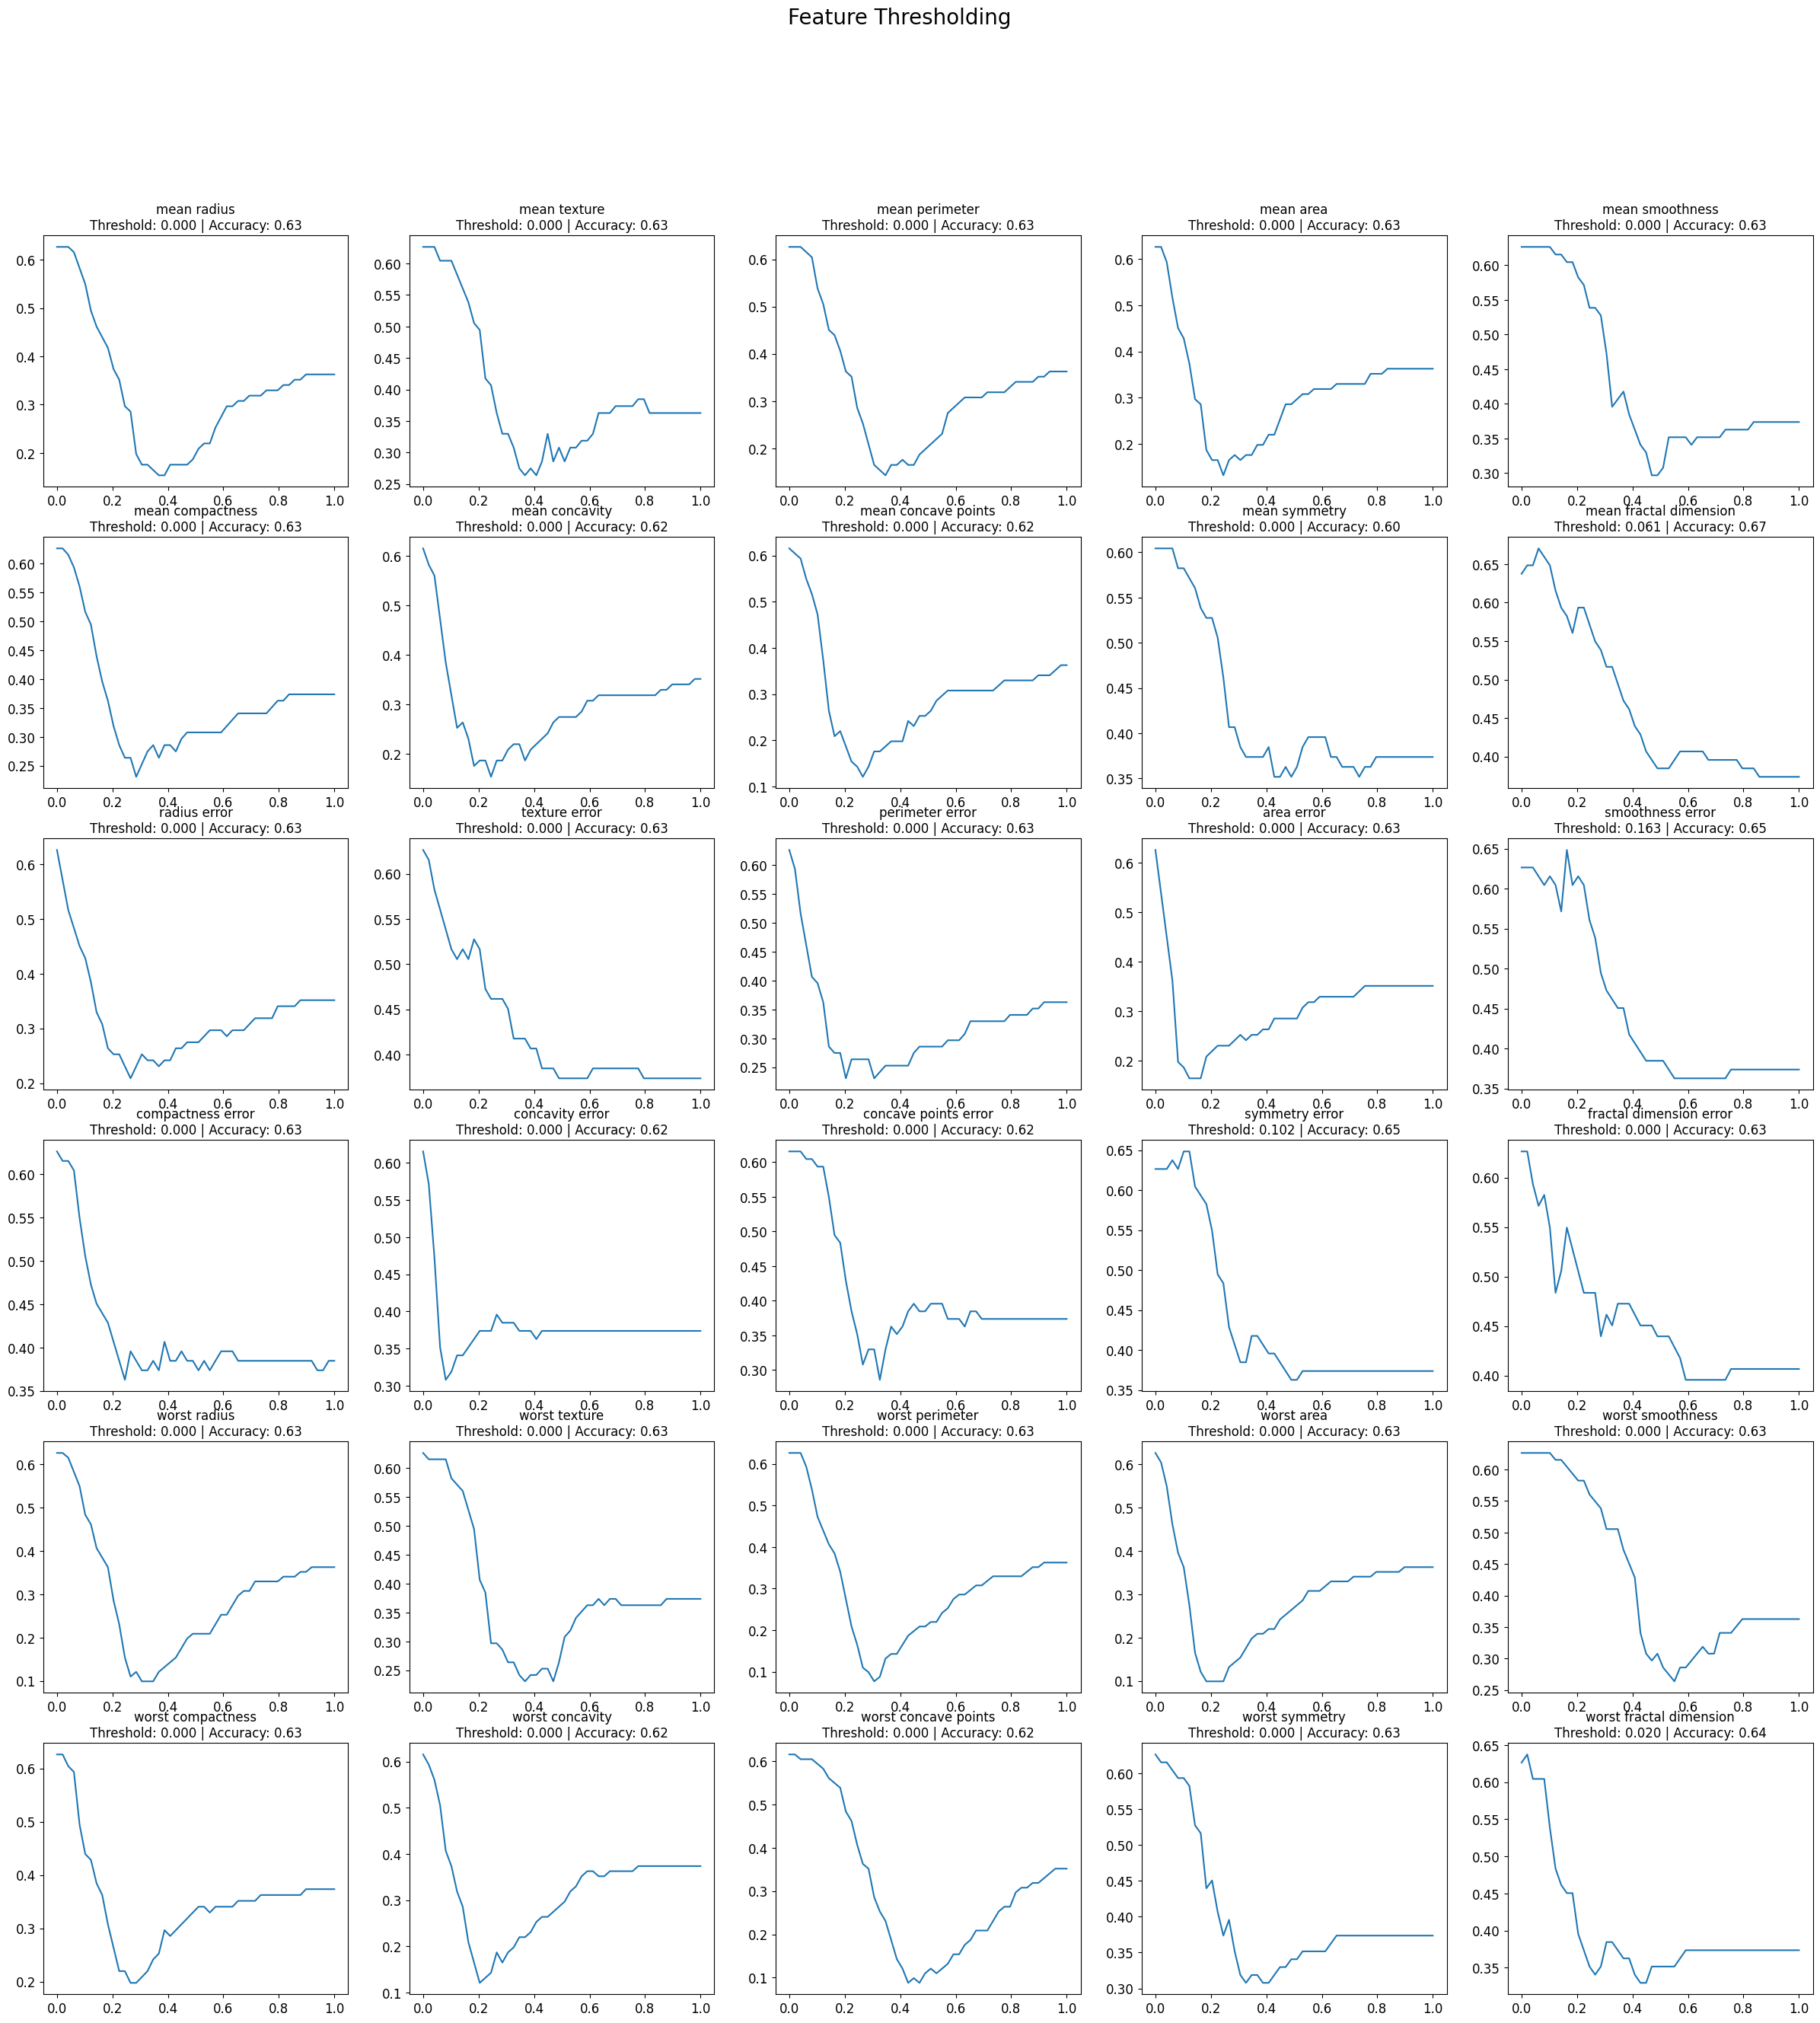

In [75]:
fig, axs = plt.subplots(6,5, figsize=(30, 30))

for i in range(30):
    max_acc = max(scores[data.feature_names[i]])
    best_threshold = thresholds[scores[data.feature_names[i]].index(max_acc)]
    axs[i//5, i%5].plot(thresholds, scores[data.feature_names[i]])
    axs[i//5, i%5].set_title(f"{data.feature_names[i]}\nThreshold: {best_threshold:.3f} | Accuracy: {max_acc:.2f}")
    
fig.suptitle("Feature Thresholding", fontsize=20)
plt.show()
    

# SVM Classifier

round(acc_score*100,2)=83.52 round(roc_auc*100,2)=80.31


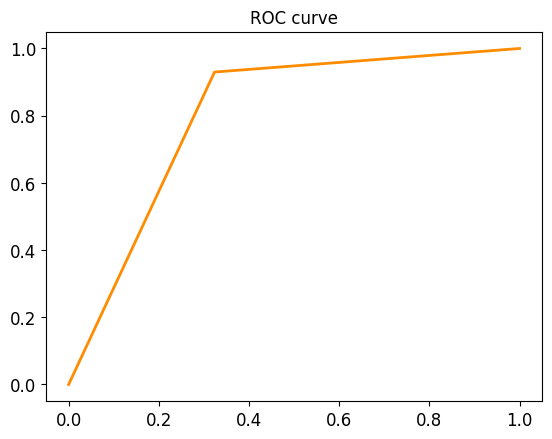

In [47]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

model_pl = Pipeline([
    ('preprocessor', preproc_pl),
    ('classifier', SVC(probability=True, kernel='linear'))
])

model_pl.fit(x_train_2[:,0].reshape(-1, 1), y_train_2)
y_pred = model_pl.predict(x_val[:,0].reshape(-1, 1))

acc_score = accuracy_score(y_val, y_pred)
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
print(f"{round(acc_score*100,2)=} {round(roc_auc*100,2)=}")
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.title('ROC curve')
plt.show()


In [84]:
def predict_each_feature(x_train, y_train, x_val, y_val, feature_number, model_pl):
    model_pl.fit(x_train[:,feature_number].reshape(-1, 1), y_train)
    y_pred = model_pl.predict(x_val[:,feature_number].reshape(-1, 1))

    acc_score = accuracy_score(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    print(f"feature-{i}: {data.feature_names[i]} {round(acc_score*100,2)=} {round(roc_auc*100,2)=}")

In [85]:
for i in range(x_train_2.shape[1]):
    predict_each_feature(x_train_2, y_train_2, x_val, y_val, i, model_pl)

feature-0: mean radius round(acc_score*100,2)=83.52 round(roc_auc*100,2)=80.31
feature-1: mean texture round(acc_score*100,2)=70.33 round(roc_auc*100,2)=64.45
feature-2: mean perimeter round(acc_score*100,2)=84.62 round(roc_auc*100,2)=81.19
feature-3: mean area round(acc_score*100,2)=86.81 round(roc_auc*100,2)=83.54
feature-4: mean smoothness round(acc_score*100,2)=70.33 round(roc_auc*100,2)=63.26
feature-5: mean compactness round(acc_score*100,2)=74.73 round(roc_auc*100,2)=72.11
feature-6: mean concavity round(acc_score*100,2)=82.42 round(roc_auc*100,2)=80.03
feature-7: mean concave points round(acc_score*100,2)=87.91 round(roc_auc*100,2)=86.79
feature-8: mean symmetry round(acc_score*100,2)=63.74 round(roc_auc*100,2)=53.84
feature-9: mean fractal dimension round(acc_score*100,2)=62.64 round(roc_auc*100,2)=50.0
feature-10: radius error round(acc_score*100,2)=79.12 round(roc_auc*100,2)=75.03
feature-11: texture error round(acc_score*100,2)=62.64 round(roc_auc*100,2)=50.0
feature-12: pe

### Build a pipeline


In [76]:
model_pl.fit(x_train_2, y_train_2)
y_pred = model_pl.predict(x_val)

acc_score = accuracy_score(y_val, y_pred)
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
print(f"{round(acc_score*100,2)=} {round(roc_auc*100,2)=}")

round(acc_score*100,2)=97.8 round(roc_auc*100,2)=97.65


# Part 5 [Student, 20 min]: ROC and AUC

The value of y_pred can also be used to plot ROC curves and calculate AUC.  Do this for two features: the one that has the highest accuracy and the one that has the lowest accuracy. How do the ROC curves look, and what is the range of AUC values?

### AUC/feature

For each feature, we will rescale the features by their max and min values (to get them into range). Then, we will build some ROC curves, considering the values of each feature as `predictions` for the target variable. This is a good way to build a baseline for a binary classification problem.

Some notes:
* The ROC curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.
** The ROC curve that is the most "bowed" towards the top-left corner indicates the best feature. This is because a curve closer to the top-left corner signifies a higher true positive rate (sensitivity) and a lower false positive rate (1-specificity) at various threshold settings. In other words, the more the curve deviates from the diagonal line (which represents random guessing), the better the feature.
** The ROC curve that is closest to the diagonal line from the bottom-left to the top-right corner indicates the worst feature. This is because the diagonal line represents a model that makes predictions no better than random guessing, with an AUC of 0.5. A feature whose ROC curve stays close to this line is the least informative for classification purposes.


*  AUC (Area Under the Curve) provides a single measure of overall model performance. An AUC of 1.0 represents a perfect model, whereas an AUC of 0.5 indicates a model that performs no better than random chance.
** Note that the worst feature is not the one with the lowest AUC, it is the one with the AUC closest to 0.5, as ones less than this are simply inverted features and could be negated to get positive performance (with AUC>0.5).
** i.e., if a feature has an AUC significantly less than 0.5, it means the model is systematically wrong more often than right, but it still contains information. By inverting the predictions (i.e., flipping the feature), it can be transformed into a useful feature with an AUC greater than 0.5.


round(acc_score*100,2)=97.8 round(roc_auc*100,2)=97.65


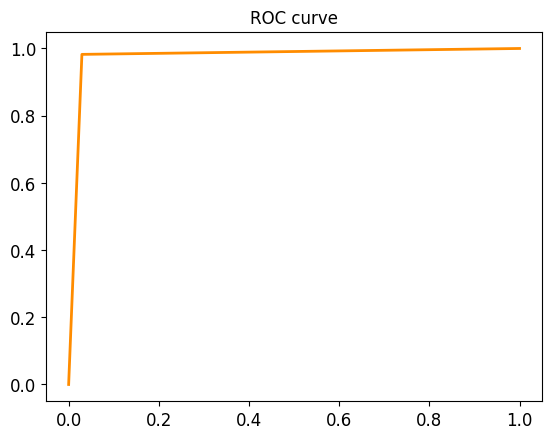

In [77]:
print(f"{round(acc_score*100,2)=} {round(roc_auc*100,2)=}")
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.title('ROC curve')
plt.show()

# Part 6 [Student, 15 min]: Decision Boundaries - Part 1

We will be looking at how to use the two features with the best accuracy scores from the previous steps. Use the below code as a starting point (make_meshgrid and plot_contours) to plot the decision boundaries of the SVM classifier from step 2 [note that the code provided here is a modified version of one of the scikit learn examplesLinks to an external site.)].  We will plot these decision boundaries using the original data, so pass in the pipeline to the plot_contours call, not just the classifier part. You will need to choose suitable ranges for make_meshgrid, based on the original feature values.

The plot will display a scatter plot of the training data points, in different colours for the two classes, on top of the decision boundary. You can also add a scatter plot of the validation data points using the same colours but different symbols [ hint: use marker=’s’ to get squares ].

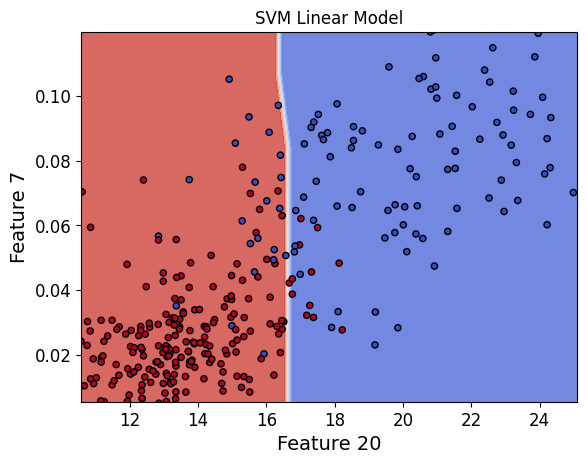

In [89]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

# We can pick up two of the best features
feature0 = 20
feature1 = 7

# For each one, extract the percentil 5 and 95. These values are useful to define the limits of our plot
x05, x95 = np.percentile(x_train_2[:,feature0],[5,95])
y05, y95 = np.percentile(x_train_2[:,feature1],[5,95])

# Create a new pipeline with SVC and a specific kernel
svm_model = SVC(kernel='linear', C = 1) # C = regularization parameter

# Define two features. We go to use the best two features identified in the previous step
feat1, feat2 = x_train_2[:, feature0], x_train_2[:, feature1]

# Train again our model using only the two features
svm_model.fit(x_train_2[:,[feature0,feature1]],y_train_2)

# We can plot a DecisionBoundary
disp = DecisionBoundaryDisplay.from_estimator(
    svm_model,                            # Define the model
    x_train_2[:,[feature0,feature1]],     # Define the data
    response_method="predict",            # Define the method used to create the boundary
    cmap=plt.cm.coolwarm,                 # Color palette
    alpha=0.8,                            # Transparency
    xlabel= f"Feature {feature0}",                  # Label 1
    ylabel= f"Feature {feature1}")                  # Label 2
# We can plot the data with its true classes
plt.scatter(feat1, feat2, c=y_train_2, cmap=plt.cm.coolwarm, s=20, edgecolors="k")

# Define the limit values of the plot
plt.xlim([x05,x95])
plt.ylim([y05,y95])
plt.title("SVM Linear Model")
plt.show()

In [ ]:
# If you have problems running the function DecisionBoundaryDisplay, tries to run the next piece of code in terminal

# pip install -U scikit-learn

# If thi does not work, try first to uninstall sklearn using

# 1) pip uninstall sklear
# 2) pip uninstall scikit-learn
# 3) pip install -U scikit-learn

### Validation
Now let's have another look, this time amend the above code so that we are using the validation set rather than the training set.

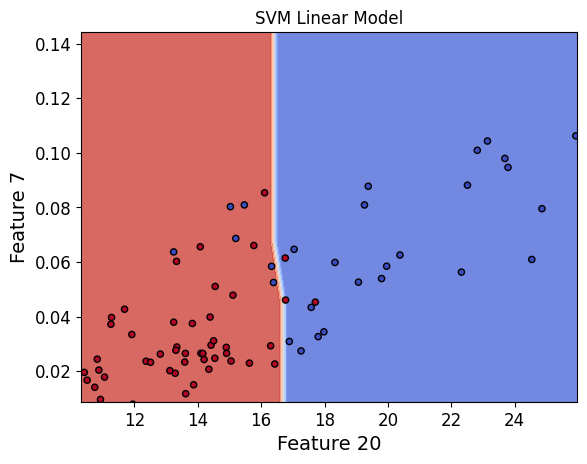

In [92]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

# We can pick up two of the best features
feature0 = 20
feature1 = 7

# For each one, extract the percentil 5 and 95. These values are useful to define the limits of our plot
x05, x95 = np.percentile(x_val[:,feature0],[5,95])
y05, y95 = np.percentile(x_val[:,feature1],[5,95])

# Create a new pipeline with SVC and a specific kernel
# svm_model = SVC(kernel='linear', C = 1) # C = regularization parameter

# Define two features. We go to use the best two features identified in the previous step
feat1, feat2 = x_val[:, feature0], x_val[:, feature1]

# Train again our model using only the two features

# We can plot a DecisionBoundary
disp = DecisionBoundaryDisplay.from_estimator(
    svm_model,                            # Define the model
    x_val[:,[feature0,feature1]],     # Define the data
    response_method="predict",            # Define the method used to create the boundary
    cmap=plt.cm.coolwarm,                 # Color palette
    alpha=0.8,                            # Transparency
    xlabel= f"Feature {feature0}",                  # Label 1
    ylabel= f"Feature {feature1}")                  # Label 2
# We can plot the data with its true classes
plt.scatter(feat1, feat2, c=y_val, cmap=plt.cm.coolwarm, s=20, edgecolors="k")

# Define the limit values of the plot
plt.xlim([x05,x95])
plt.ylim([y05,y95])
plt.title("SVM Linear Model")
plt.show()

### Fiddling with C Values
C is a regularisation parameter. The higher the C, the bigger the margin (it is ignoring misclassifications).

Try and write some code to explore different values of C, and inspect the plots. What do you notice?

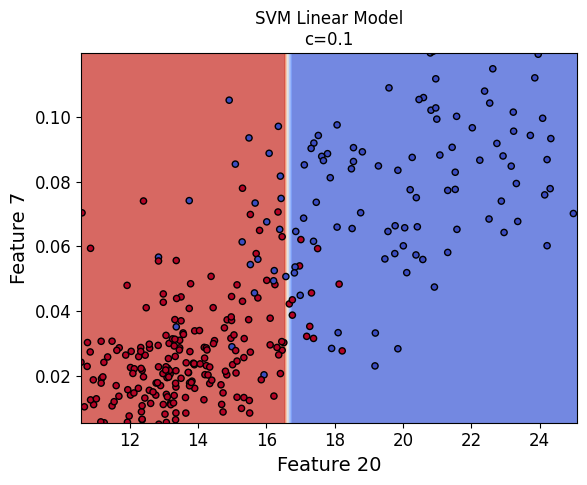

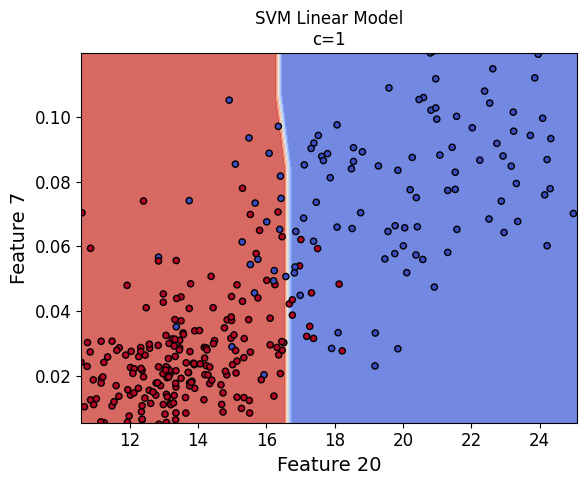

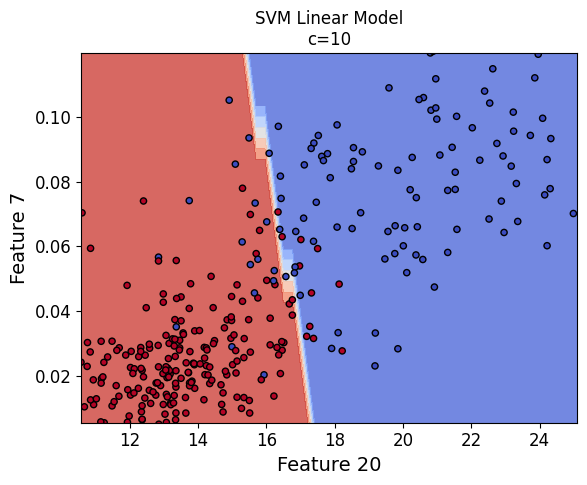

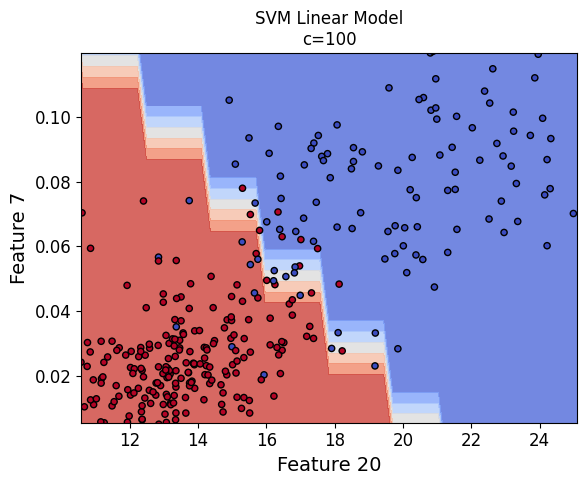

In [96]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

for c in [0.1, 1, 10, 100]:
    # We can pick up two of the best features
    feature0 = 20
    feature1 = 7

    # For each one, extract the percentil 5 and 95. These values are useful to define the limits of our plot
    x05, x95 = np.percentile(x_train_2[:,feature0],[5,95])
    y05, y95 = np.percentile(x_train_2[:,feature1],[5,95])

    # Create a new pipeline with SVC and a specific kernel
    svm_model = SVC(kernel='linear', C = c) # C = regularization parameter

    # Define two features. We go to use the best two features identified in the previous step
    feat1, feat2 = x_train_2[:, feature0], x_train_2[:, feature1]

    # Train again our model using only the two features
    svm_model.fit(x_train_2[:,[feature0,feature1]],y_train_2)

    # We can plot a DecisionBoundary
    disp = DecisionBoundaryDisplay.from_estimator(
        svm_model,                            # Define the model
        x_train_2[:,[feature0,feature1]],     # Define the data
        response_method="predict",            # Define the method used to create the boundary
        cmap=plt.cm.coolwarm,                 # Color palette
        alpha=0.8,                            # Transparency
        xlabel= f"Feature {feature0}",                  # Label 1
        ylabel= f"Feature {feature1}")                  # Label 2
    # We can plot the data with its true classes
    plt.scatter(feat1, feat2, c=y_train_2, cmap=plt.cm.coolwarm, s=20, edgecolors="k")

    # Define the limit values of the plot
    plt.xlim([x05,x95])
    plt.ylim([y05,y95])
    plt.title(f"SVM Linear Model\n{c=}")
    plt.show()

# Part 7 [Student, 15 min]: Decision Boundaries - Part 2

Re-run the SVM classification with polynomial (‘poly’) and radial basis function (‘rbf’) kernels. Compare the results in terms of accuracy and plots of the decision boundaries.

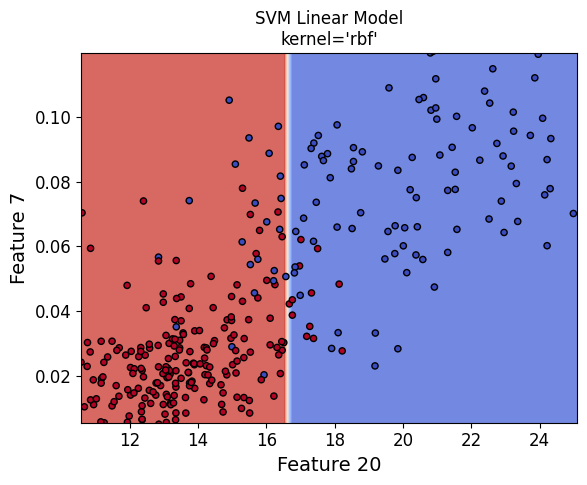

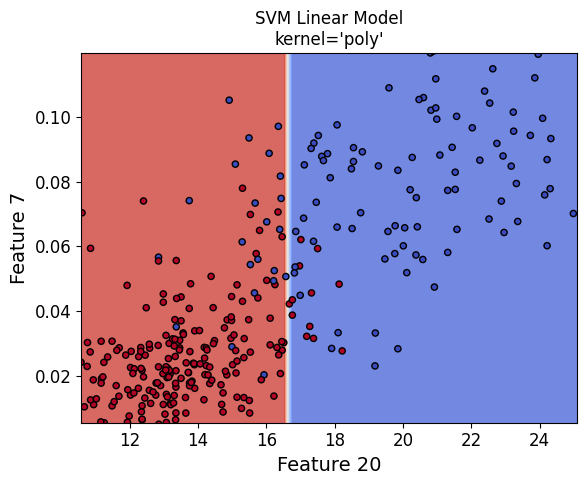

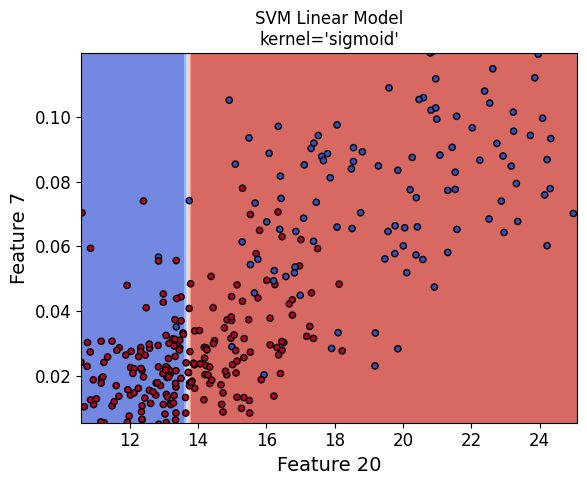

In [97]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

for kernel in ['rbf', 'poly', 'sigmoid']:
    # We can pick up two of the best features
    feature0 = 20
    feature1 = 7

    # For each one, extract the percentil 5 and 95. These values are useful to define the limits of our plot
    x05, x95 = np.percentile(x_train_2[:,feature0],[5,95])
    y05, y95 = np.percentile(x_train_2[:,feature1],[5,95])

    # Create a new pipeline with SVC and a specific kernel
    svm_model = SVC(kernel=kernel, C = 10) # C = regularization parameter

    # Define two features. We go to use the best two features identified in the previous step
    feat1, feat2 = x_train_2[:, feature0], x_train_2[:, feature1]

    # Train again our model using only the two features
    svm_model.fit(x_train_2[:,[feature0,feature1]],y_train_2)

    # We can plot a DecisionBoundary
    disp = DecisionBoundaryDisplay.from_estimator(
        svm_model,                            # Define the model
        x_train_2[:,[feature0,feature1]],     # Define the data
        response_method="predict",            # Define the method used to create the boundary
        cmap=plt.cm.coolwarm,                 # Color palette
        alpha=0.8,                            # Transparency
        xlabel= f"Feature {feature0}",                  # Label 1
        ylabel= f"Feature {feature1}")                  # Label 2
    # We can plot the data with its true classes
    plt.scatter(feat1, feat2, c=y_train_2, cmap=plt.cm.coolwarm, s=20, edgecolors="k")

    # Define the limit values of the plot
    plt.xlim([x05,x95])
    plt.ylim([y05,y95])
    plt.title(f"SVM Linear Model\n{kernel=}")
    plt.show()

# Extension: Model selection

As an extension, you can choose the best classifier and report the results on the test set.  Check to see how different it is from the validation set result. Below are is some example code that the students will not initially have.
